# Working with surftemp-sst data


## Tutorial 1 - Getting Started

This tutorial helps you get started with the Sea Surface Temperature Daily Analysis dataset: European Space Agency Climate Change Initiative product version 2.1, hosted by AWS opendata.

A brief summary of this dataset is:

> Global daily-mean sea surface temperatures, presented on a 0.05° latitude-longitude grid, with gaps between available daily observations filled by statistical means, spanning late 1981 to recent time.
>
> Synthesised from multiple Earth orbiting satellites carrying infrared imagers from thousands of billions of individual measurements. Underlying observation resolution ranges from 1 to 20 km, and after gap filling the typical feature resolution is ~20 km. Suitable for large-scale oceanographic meteorological and climatological applications, such as evaluating or constraining environmental models or case-studies of marine heat wave events.
>
> Adhering to community data standards and names. Includes temperature uncertainty information and auxiliary information about land-sea fraction and sea-ice coverage. To understand the data for your application, read the paper [1] using <a href="www.nature.com/articles/s41597-019-0236-x">www.nature.com/articles/s41597-019-0236-x</a> to cite in any published usage.
>
> The v2.1 record is known to have biases associated with desert dust aerosol and erratic calibration of early-record sensors [1]. Adjustments to reduce these biases and include additional uncertainty in these effects have been developed, as described in [2] and are applied to this data. These adjustments operate on monthly and >5 degree time-space scales.
> 
> [1] Merchant, C.J., Embury, O., Bulgin, C.E., Block, T., Corlett, G.K., Fiedler, E., Good, S.A., Mittaz, J., Rayner, N.A., Berry, D., Eastwood, S., Taylor, M., Tsushima, Y., Waterfall, A., Wilson, R. and Donlon, C. (2019), Satellite-based time-series of sea-surface temperature since 1981 for climate applications. Scientific Data 6, 223, doi:10.1038/s41597-019-0236-x
>
> [2] Merchant, C.J. and Embury, O. (2020) Adjusting for desert-dust-related biases in a climate data record of sea surface temperature. Remote Sensing, 12 (16). 2554. ISSN 2072-4292 doi:10.3390/rs12162554

Although the entire datset is over 300Gb in size, a subset of the data can be downloaded selectively to inspect particular areas, locations or time periods.  This tutorial will provide some basic examples of how to do this using the [xarray library]( http://xarray.pydata.org/en/stable/)

### 1.0 Installing dependencies

Important!  You'll need the following dependencies installed for this notebook to run

In [8]:
%pip install xarray
%pip install zarr
%pip install s3fs
%pip install matplotlib
%pip install dask

You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/cv922550/venvs/sst_data/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import s3fs
import xarray as xr
import matplotlib

### 1.1 Opening the dataset

The following code will load the data and create an SST dataset

In [9]:
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root="s3://surftemp-sst/sst.zarr", s3=s3, create=False)
sst_ds = xr.open_zarr(store)

### 1.2 Inspecting the dataset

The main variables are

| Variable name         | Description                                              | Units   |
| --------------------- | -------------------------------------------------------- | ------- |
| analysed_sst          | Analysed sea surface temperature (Kelvin)                | kelvin  |
| analysis_uncertainty  | Estimated error standard deviation of analysed_sst       | kelvin  |
| sea_ice_fraction      | The estimated fraction of the area covered by sea ice    | -       |
| mask                  | Bit mask (bit0:sea,bit1:land:bit2:lake,bit3:ice)         | -       |


In [11]:
sst_ds

<xarray.Dataset>
Dimensions:                   (time: 14367, lat: 3600, lon: 7200, bnds: 2)
Coordinates:
  * lat                       (lat) float32 -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon                       (lon) float32 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1981-09-01T12:00:00 ... 2...
Dimensions without coordinates: bnds
Data variables:
    analysed_sst              (time, lat, lon) float32 dask.array<chunksize=(50, 360, 720), meta=np.ndarray>
    analysed_sst_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(50, 360, 720), meta=np.ndarray>
    lat_bnds                  (lat, bnds) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lon_bnds                  (lon, bnds) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    mask                      (time, lat, lon) float32 dask.array<chunksize=(50, 360, 720), meta=np.ndarray>
    sea_ice_fraction          (time, lat, lon) float32 dask.array<chunksize=(50, 360, 720), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                     CF-1.5, Unidata Observation Dataset v1.0
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  Funded by the Copernicus Climate Change ...
    cdm_data_type:                   grid
    comment:                         These data were produced by the Met Offi...
    contact:                         http://copernicus-support.ecmwf.int
    ...                              ...
    time_coverage_resolution:        P1D
    time_coverage_start:             20201215T000000Z
    title:                           C3S SST L4 product
    tracking_id:                     7fdf2639-26e5-4d4f-a60e-0bcfc9744204
    uuid:                            7fdf2639-26e5-4d4f-a60e-0bcfc9744204
    westernmost_longitude:           -180.0

### 1.3 Obtaining a timeseries

the data covers the earth's surface at a resolution of 0.05 degrees.  If interested in temperatures at a single location, extract a time series.  You can also specify a reduced time period. 

In [13]:
# get the data for the closest cell to a particular latitude and longitude of interest
ssts_ts = sst_ds["analysed_sst"].sel(lat=51,lon=-38,method="nearest")

In [14]:
# narrow down further to a 4 year time period covering the years 1982 to 1985
ssts_ts_sel = ssts_ts.sel(time=slice("1982-01-01","1985-12-31"))

In [15]:
# optional - calling the load method explitly triggers the download of the required parts of the
# dataset from AWS opendata into memory.
ssts_ts_sel = ssts_ts_sel.load()

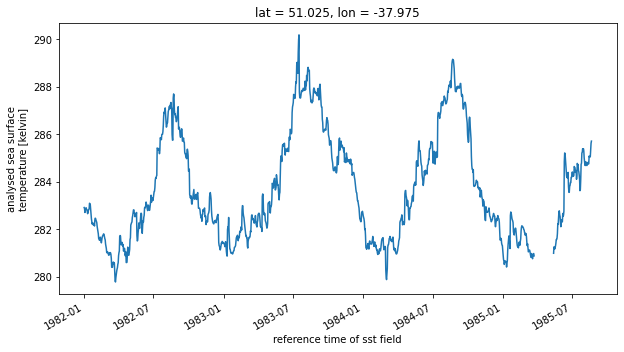

In [16]:
# plot the time series
ssts_ts_sel.plot(figsize=(10,5))

### 1.4 Obtaining data for a specific region

it is easy to select a subset of the data for  given range of latitudes and longitudes.  For example, to fetch the data for a region (the gulf of guinea) at a single point in time:

In [17]:
ssts_ts = sst_ds["analysed_sst"].sel(time="2006-02-23").sel(lat=slice(-5,10),lon=slice(-5,10)).load()

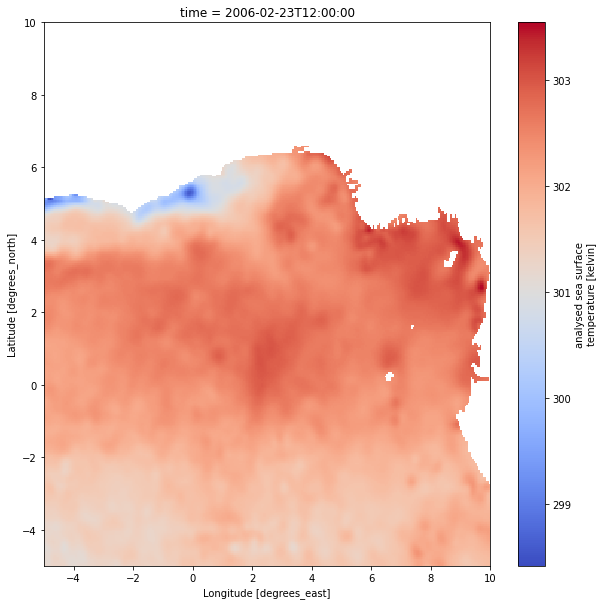

In [44]:
ssts_ts.plot(cmap="coolwarm",figsize=(10,10))

In [1]:
### 1.5 Plotting global sea surface temperatures at a point in time

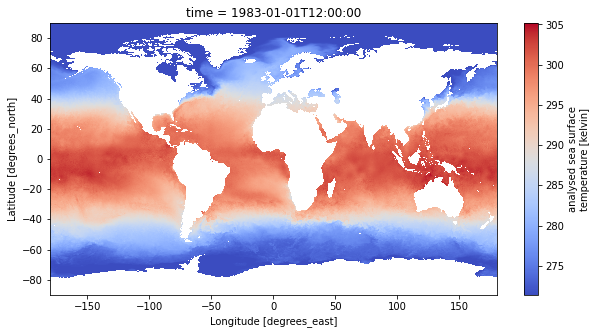

In [8]:
global_ssts = sst_ds["analysed_sst"].sel(time="1983-01-01").load()
global_ssts.plot(cmap="coolwarm",figsize=(10,5))

### 1.6 Inspecting other variables in the dataset

fetch the SST uncertainty data for a region (the gulf of guinea) at a single point in time:

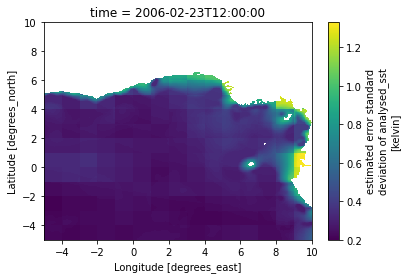

In [18]:
sst_ds["analysed_sst_uncertainty"].sel(time="2006-02-23").sel(lat=slice(-5,10),lon=slice(-5,10)).plot()

plot global sea ice fraction on the first day in 1983

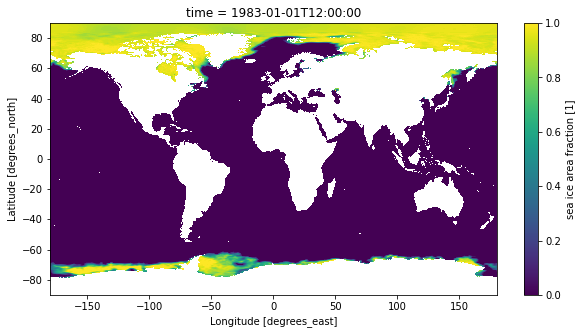

In [13]:
global_sea_ice_fraction = sst_ds["sea_ice_fraction"].sel(time="1983-01-01")
global_sea_ice_fraction.plot(figsize=(10,5))

Plot the mask over Scandanavia

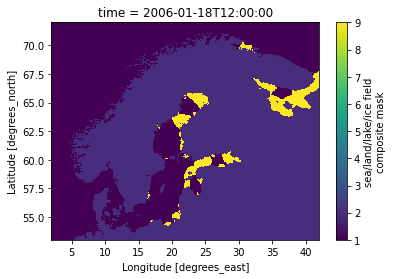

In [23]:
sst_ds["mask"].sel(time="2006-01-18").sel(lon=slice(2,42),lat=slice(53,72)).plot()